<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Basics_of_lora_implementation_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Define a transform to normalize the data and flatten each image into a 1D array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data)
    target = torch.tensor(target)
    return data.cuda(), target.cuda()

In [3]:
def plot_flattened_images(flattened_images, labels, img_shape, class_names, num_images=5):
    """
    Plots images that have been flattened.

    Parameters:
        flattened_images (torch.Tensor): The flattened images tensor.
        labels (torch.Tensor): The labels tensor.
        img_shape (tuple): The original shape of the images (e.g., (28, 28) for Fashion MNIST).
        class_names (list): List of class names.
        num_images (int): Number of images to plot.
    """
    # Reshape the flattened images back to their original shape
    reshaped_images = flattened_images.view(-1, *img_shape).numpy()

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

    for i, ax in enumerate(axes):
        img = reshaped_images[i]
        label = class_names[labels[i].item()]
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)


100%|██████████| 26421880/26421880 [00:00<00:00, 113593882.87it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4627846.08it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 66829672.93it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24481039.67it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



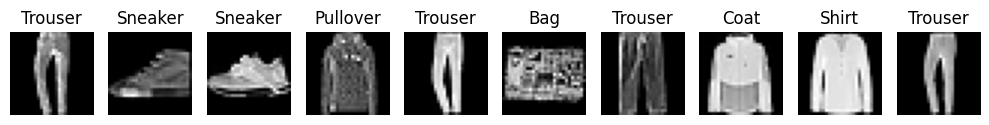

In [5]:
# Get one batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [6]:

class FashionNet(nn.Module):
  def __init__(self, input_dims, num_class):

    super().__init__()
    self.input_dims = input_dims
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=512)
    self.hidden_layer = nn.Linear(in_features=512, out_features=256)
    self.output_layer = nn.Linear(in_features=256, out_features=self.num_class)

  def forward(self, x):
    out = F.relu(self.input_layer(x))
    out = F.relu(self.hidden_layer(out))
    out = self.output_layer(out)
    return out

In [7]:
# Check for GPU availability
cuda_available = torch.cuda.is_available()

In [8]:
BigNet = FashionNet(input_dims=784, num_class=len(class_names))
optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume `model` is your model
if cuda_available:
    BigNet = BigNet.to('cuda')
    optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to('cuda')


In [9]:
is_on_gpu = next(BigNet.parameters()).is_cuda
print(f'Model is on GPU: {is_on_gpu}')

Model is on GPU: True


In [10]:
trainable_params = sum(p.numel() for p in BigNet.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

Number of trainable (tunable) parameters: 535818


In [11]:
import torch

def train_model(epochs:int, train_loader, model, optimizer, criterion):
  model.train()
  train_loss_per_epoch = []

  for epoch in range(epochs):

    running_loss_train = 0.0

    for data_batch, target_batch in train_loader:

        data_batch = data_batch.to('cuda')
        target_batch = target_batch.to('cuda')

        optimizer.zero_grad()
        output = model(data_batch)
        loss_train = criterion(output, target_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item()

    epcoh_loss_train = running_loss_train / len(train_loader)

    train_loss_per_epoch.append(epcoh_loss_train)


    if epoch %5 == 0:
      print(f'Epoch {epoch} Train loss {epcoh_loss_train}')
  return train_loss_per_epoch



import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def test_model(test_loader, model, criterion, class_labels):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data_batch, target_batch in test_loader:
            data_batch = data_batch.to('cuda')
            target_batch = target_batch.to('cuda')

            output = model(data_batch)
            loss = criterion(output, target_batch)
            test_loss += loss.item() * len(data_batch)  # correct loss accumulation

            _, predicted = torch.max(output.data, 1)  # get the index of the max log-probability
            all_targets.extend(target_batch.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)  # get average loss

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Compute class-wise number of wrong predictions
    class_wise_wrong_preds = cm.sum(axis=1) - np.diag(cm)

    # Create a dictionary to store class-wise wrong predictions with label info
    wrong_preds_dict = {class_labels[i]: class_wise_wrong_preds[i] for i in range(len(class_labels))}

    return test_loss, wrong_preds_dict



In [12]:
trainLoss = train_model(epochs=20,
                        train_loader=trainloader,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Epoch 0 Train loss 1.383198184482122
Epoch 5 Train loss 0.4424403638152753
Epoch 10 Train loss 0.3823874552371138
Epoch 15 Train loss 0.3453267262143604


In [14]:
# Call the function
testlLoss, wrong_pred = test_model(
                        test_loader=testloader,
                        model=BigNet,
                        criterion=criterion,
                        class_labels=class_names)

In [15]:
wrong_pred

{'T-shirt/top': 238,
 'Trouser': 42,
 'Pullover': 283,
 'Dress': 130,
 'Coat': 206,
 'Sandal': 52,
 'Shirt': 294,
 'Sneaker': 85,
 'Bag': 33,
 'Ankle boot': 52}

In [16]:
# Load the entire dataset
full_trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Get the indices for the Shirt and T-shirt categories
shirt_tshirt_indices = [i for i, (data, target) in enumerate(full_trainset) if target == 0 or target == 6]

# Create a subset of the data for Shirt and T-shirt categories
shirt_tshirt_subset = torch.utils.data.Subset(full_trainset, shirt_tshirt_indices)

# Create the data loader for Shirt and T-shirt categories
shirt_tshirt_subset = torch.utils.data.DataLoader(shirt_tshirt_subset, batch_size=1024, shuffle=True)

# Get the indices for the other categories (excluding Shirt and T-shirt)
indices_without_shirt_t_shirt = [i for i, (data, target) in enumerate(full_trainset) if target != 0 and target != 6]

# Create a subset of the data for other categories
other_subset = torch.utils.data.Subset(full_trainset, indices_without_shirt_t_shirt)

# Create the data loader for other categories
data_without_shirt_t_shirt = torch.utils.data.DataLoader(other_subset, batch_size=1024, shuffle=True)

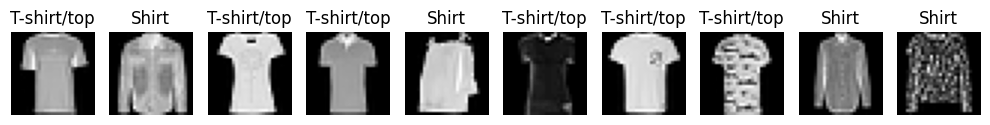

In [18]:
# Get one batch of images and labels
dataiter = iter(shirt_tshirt_subset)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [20]:
# saving the original model weights

original_weights = {}
for name, parm in BigNet.named_parameters():
  original_weights[name] = parm.clone()

In [24]:
class LoRaParametarization(nn.Module):

    def __init__(self, r: int, lora_alpha: int, feature_in: int, feature_out:int):
        super().__init__()
        self.r = r
        self.lora_alpha = lora_alpha

        self.lora_A = nn.Parameter(torch.zeros(r, feature_out)).to('cuda')
        self.lora_B = nn.Parameter(torch.zeros(feature_in, r)).to('cuda')
        nn.init.normal_(self.lora_A, mean=0, std=1)

        self.scale = self.lora_alpha / self.r
        self.lora_enabled = True

    def forward(self, original_weights):

      if self.lora_enabled:
        return original_weights + torch.matmul(self.lora_B , self.lora_A).view(original_weights.shape) * self.scale

      return original_weights


def linear_layer_parameterization(layer, r:int=1, lora_alpha:int=1):

  feature_in, feature_out = layer.weight.shape

  return LoRaParametarization(r=r, lora_alpha=lora_alpha, feature_in=feature_in, feature_out=feature_out)

P.register_parametrization(BigNet.input_layer, "weight", linear_layer_parameterization(BigNet.input_layer))
P.register_parametrization(BigNet.hidden_layer, "weight", linear_layer_parameterization(BigNet.hidden_layer))
P.register_parametrization(BigNet.output_layer, "weight", linear_layer_parameterization(BigNet.output_layer))

def enable_disable_lora(enabled=True):
  for layer in [BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]:
    layer.parametrizations["weight"][0].enabled = enabled

In [25]:
total_parameters_original = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([512, 784]) + B: torch.Size([512])
Layer 2: W: torch.Size([256, 512]) + B: torch.Size([256])
Layer 3: W: torch.Size([10, 256]) + B: torch.Size([10])
Total number of parameters: 535,818


In [27]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([512, 784]) + B: torch.Size([512]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([512, 1])
Layer 2: W: torch.Size([256, 512]) + B: torch.Size([256]) + Lora_A: torch.Size([1, 512]) + Lora_B: torch.Size([256, 1])
Layer 3: W: torch.Size([10, 256]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 256]) + Lora_B: torch.Size([10, 1])
Total number of parameters (original): 535,818
Total number of parameters (original + LoRA): 538,148
Parameters introduced by LoRA: 2,330
Parameters incremment: 0.435%


In [43]:
enable_disable_lora(enabled=True)

In [44]:
# Freeze the non-Lora parameters
for name, param in BigNet.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False



# Train the network with LoRA only on the digit 9 and only for 100 batches (hoping that it would improve the performance on the digit 9)
# train(train_loader, net, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter input_layer.bias
Freezing non-LoRA parameter input_layer.parametrizations.weight.original
Freezing non-LoRA parameter hidden_layer.bias
Freezing non-LoRA parameter hidden_layer.parametrizations.weight.original
Freezing non-LoRA parameter output_layer.bias
Freezing non-LoRA parameter output_layer.parametrizations.weight.original


In [45]:
BigNet

FashionNet(
  (input_layer): ParametrizedLinear(
    in_features=784, out_features=512, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRaParametarization()
      )
    )
  )
  (hidden_layer): ParametrizedLinear(
    in_features=512, out_features=256, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRaParametarization()
      )
    )
  )
  (output_layer): ParametrizedLinear(
    in_features=256, out_features=10, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRaParametarization()
      )
    )
  )
)

In [46]:
trainLoss = train_model(epochs=30,
                        train_loader=shirt_tshirt_subset,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Epoch 0 Train loss 0.5393292456865311
Epoch 5 Train loss 0.5391529500484467
Epoch 10 Train loss 0.537925660610199
Epoch 15 Train loss 0.5398494253555933
Epoch 20 Train loss 0.5396106739838918
Epoch 25 Train loss 0.5384441713492075


In [34]:
trainLoss

[0.5387151911854744,
 0.5380379731456438,
 0.538431316614151,
 0.537735253572464,
 0.5391638924678167,
 0.5400051226218542,
 0.539530615011851,
 0.5378728806972504,
 0.5387518008550009,
 0.5382405171791712]

In [35]:
# Call the function
testlLoss, wrong_pred = test_model(
                        test_loader=testloader,
                        model=BigNet,
                        criterion=criterion,
                        class_labels=class_names)

In [36]:
wrong_pred

{'T-shirt/top': 238,
 'Trouser': 42,
 'Pullover': 283,
 'Dress': 130,
 'Coat': 206,
 'Sandal': 52,
 'Shirt': 294,
 'Sneaker': 85,
 'Bag': 33,
 'Ankle boot': 52}

In [37]:
enable_disable_lora(enabled=False)
# Call the function
testlLoss, wrong_pred = test_model(
                        test_loader=testloader,
                        model=BigNet,
                        criterion=criterion,
                        class_labels=class_names)
wrong_pred

{'T-shirt/top': 238,
 'Trouser': 42,
 'Pullover': 283,
 'Dress': 130,
 'Coat': 206,
 'Sandal': 52,
 'Shirt': 294,
 'Sneaker': 85,
 'Bag': 33,
 'Ankle boot': 52}